# Libraries

In [1]:
import os
import cv2
import numpy as np
import csv
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random



# Functions

In [2]:
def get_bbox_from_file(file_path):
    """Read bounding boxes from a .txt file."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    bboxes = [list(map(int, line.strip().split(','))) for line in lines]
    return bboxes

In [3]:
def crop_and_save(image_path, mask_path, bboxes, save_img_dir, save_mask_dir, subject, img_name):
    """Crop and save all boxes from one image with improved handling of small tumors."""
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    image_name = img_name.replace(".png", "")
    meta_rows = []
    h_img, w_img = image.shape[:2]

    for i, (xmin, ymin, xmax, ymax) in enumerate(bboxes):
        orig_w = xmax - xmin
        orig_h = ymax - ymin
        
        # Skip if completely invalid
        if orig_w <= 0 or orig_h <= 0:
            continue
        
        # For very small tumors, expand context while preserving tumor location
        if orig_w < 16 or orig_h < 16:
            center_x = (xmin + xmax) // 2
            center_y = (ymin + ymax) // 2
            
            # Expand to minimum 32x32 with context
            expand_size = 32
            new_xmin = max(0, center_x - expand_size//2)
            new_xmax = min(w_img, center_x + expand_size//2)
            new_ymin = max(0, center_y - expand_size//2)
            new_ymax = min(h_img, center_y + expand_size//2)
            
            # Adjust if we hit image boundaries
            if new_xmax - new_xmin < expand_size:
                if new_xmin == 0:
                    new_xmax = min(w_img, expand_size)
                else:
                    new_xmin = max(0, w_img - expand_size)
            
            if new_ymax - new_ymin < expand_size:
                if new_ymin == 0:
                    new_ymax = min(h_img, expand_size)
                else:
                    new_ymin = max(0, h_img - expand_size)
                    
            xmin, ymin, xmax, ymax = new_xmin, new_ymin, new_xmax, new_ymax

        cropped_img = image[ymin:ymax, xmin:xmax]
        cropped_mask = mask[ymin:ymax, xmin:xmax]

        if cropped_img.size == 0 or cropped_mask.size == 0:
            continue

        # Resize to 64x64
        cropped_img = cv2.resize(cropped_img, (64, 64))
        cropped_mask = cv2.resize(cropped_mask, (64, 64), interpolation=cv2.INTER_NEAREST)

        filename = f"{subject}_{image_name}_{i}.png"
        img_save_path = os.path.join(save_img_dir, filename)
        mask_save_path = os.path.join(save_mask_dir, filename)

        cv2.imwrite(img_save_path, cropped_img)
        cv2.imwrite(mask_save_path, cropped_mask)

        meta_rows.append([filename, subject, img_name, xmin, ymin, xmax, ymax, orig_w, orig_h])

    return meta_rows


In [4]:
def process_split(split):
    """Process either 'train' or 'val'."""
    base_dir = Path("LungTumorDetectionAndSegmentation") / split
    images_dir = base_dir / "images"
    masks_dir = base_dir / "masks"
    det_dir = base_dir / "detections"

    save_img_dir = Path(f"cropped_data/{split}/images")
    save_mask_dir = Path(f"cropped_data/{split}/masks")
    save_img_dir.mkdir(parents=True, exist_ok=True)
    save_mask_dir.mkdir(parents=True, exist_ok=True)

    csv_path = Path(f"cropped_data/{split}/metadata.csv")
    with open(csv_path, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["filename", "subject", "image_file", "xmin", "ymin", "xmax", "ymax", "orig_w", "orig_h"])

        for subject in tqdm(os.listdir(det_dir), desc=f"Processing {split}"):
            det_subject_dir = det_dir / subject
            for det_file in os.listdir(det_subject_dir):
                if not det_file.endswith('.txt'):
                    continue

                img_name = det_file.replace('.txt', '.png')
                img_path = images_dir / subject / img_name
                mask_path = masks_dir / subject / img_name
                det_path = det_subject_dir / det_file

                if not img_path.exists() or not mask_path.exists():
                    continue

                bboxes = get_bbox_from_file(det_path)
                metadata_rows = crop_and_save(str(img_path), str(mask_path), bboxes, str(save_img_dir), str(save_mask_dir), subject, img_name)

                for row in metadata_rows:
                    writer.writerow(row)

# Cropped Images Creation

In [6]:
# Run for both splits
process_split("train")
process_split("val")

Processing val: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


# Test image

In [7]:
show_image = cv2.imread('cropped_data/train/images/Subject_0_308_0.png')
print(f"Image shape: {show_image.shape}")

show_mask = cv2.imread('cropped_data/train/masks/Subject_0_308_0.png')
print(f"Mask shape: {show_mask.shape}")

Image shape: (64, 64, 3)
Mask shape: (64, 64, 3)


# Dataset Class

In [8]:
class TumorCropDatasetAugmented(Dataset):
    def __init__(self, image_dir, mask_dir, metadata_csv=None, augment=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.augment = augment
        
        # Load metadata for size-adaptive augmentation
        self.metadata = {}
        if metadata_csv and os.path.exists(metadata_csv):
            with open(metadata_csv, 'r') as f:
                reader = csv.DictReader(f)
                for row in reader:
                    self.metadata[row['filename']] = {
                        'orig_w': int(row['orig_w']),
                        'orig_h': int(row['orig_h'])
                    }

    def __len__(self):
        return len(self.image_filenames)

    def apply_synchronized_transforms(self, image_pil, mask_pil, orig_size):
        """Apply synchronized transforms to image and mask"""
        if not self.augment:
            return image_pil, mask_pil
            
        # Size-adaptive augmentation
        max_size = max(orig_size) if orig_size else 32
        
        # Reduce augmentation intensity for very small tumors
        if max_size < 8:
            flip_prob = 0.3
            rotation_deg = 0
            jitter_intensity = 0.05
        elif max_size < 16:
            flip_prob = 0.4
            rotation_deg = 5
            jitter_intensity = 0.1
        else:
            flip_prob = 0.5
            rotation_deg = 15
            jitter_intensity = 0.2
        
        # Apply synchronized geometric transforms
        if random.random() < flip_prob:
            image_pil = TF.hflip(image_pil)
            mask_pil = TF.hflip(mask_pil)
        
        if random.random() < flip_prob:
            image_pil = TF.vflip(image_pil)
            mask_pil = TF.vflip(mask_pil)
        
        if rotation_deg > 0:
            angle = random.uniform(-rotation_deg, rotation_deg)
            image_pil = TF.rotate(image_pil, angle, fill=0)
            mask_pil = TF.rotate(mask_pil, angle, fill=0)
        
        # Apply color jitter only to image
        if jitter_intensity > 0:
            color_jitter = transforms.ColorJitter(
                brightness=jitter_intensity, 
                contrast=jitter_intensity, 
                saturation=jitter_intensity
            )
            image_pil = color_jitter(image_pil)
        
        return image_pil, mask_pil

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert to PIL for transforms
        image_pil = Image.fromarray(image)
        mask_pil = Image.fromarray(mask)
        
        # Get original size for adaptive augmentation
        orig_size = None
        if img_name in self.metadata:
            orig_size = (self.metadata[img_name]['orig_w'], self.metadata[img_name]['orig_h'])
        
        # Apply synchronized transforms
        image_pil, mask_pil = self.apply_synchronized_transforms(image_pil, mask_pil, orig_size)
        
        # Convert back to numpy
        image = np.array(image_pil).astype(np.float32) / 255.0
        mask = np.array(mask_pil)
        mask = (mask > 0).astype(np.float32)
        
        image = np.transpose(image, (2, 0, 1))  # HWC to CHW

        return {
            "image": torch.tensor(image, dtype=torch.float32),
            "mask": torch.tensor(mask, dtype=torch.float32).unsqueeze(0),
            "orig_size": orig_size if orig_size else (32, 32)
        }


# U-Net

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.15),  # Slightly increased dropout
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [10]:

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Downsampling path (encoder)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Upsampling path (decoder)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # transpose conv
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)


# Training + Validation Functions

In [11]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    epoch_loss = 0
    for batch in loader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        # Forward pass
        preds = model(images)
        loss = loss_fn(preds, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        epoch_loss += loss.item()
    
    return epoch_loss / len(loader)

In [12]:
def evaluate(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            preds = model(images)
            loss = loss_fn(preds, masks)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [13]:
class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.4, dice_weight=0.6, smooth=1):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.smooth = smooth

    def forward(self, inputs, targets):
        # BCE loss
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        # Dice loss
        inputs_sig = torch.sigmoid(inputs)       
        inputs_flat = inputs_sig.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()                            
        dice = (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)  
        dice_loss = 1 - dice
        
        return self.bce_weight * bce + self.dice_weight * dice_loss

In [14]:
def calculate_metrics(model, loader, device):
    """Calculate comprehensive metrics"""
    model.eval()
    total_iou = 0
    total_dice = 0
    total_pixel_acc = 0
    num_samples = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)
            
            preds = torch.sigmoid(model(images))
            preds_binary = (preds > 0.5).float()
            
            # Flatten for calculations
            pred_flat = preds_binary.view(preds.size(0), -1)
            mask_flat = masks.view(masks.size(0), -1)
            
            for i in range(pred_flat.size(0)):
                pred_i = pred_flat[i]
                mask_i = mask_flat[i]
                
                # Pixel accuracy
                pixel_acc = (pred_i == mask_i).float().mean().item()
                
                # IoU (Jaccard Index)
                intersection = (pred_i * mask_i).sum().item()
                union = pred_i.sum().item() + mask_i.sum().item() - intersection
                iou = intersection / (union + 1e-8)
                
                # Dice coefficient
                dice = (2 * intersection) / (pred_i.sum().item() + mask_i.sum().item() + 1e-8)
                
                total_pixel_acc += pixel_acc
                total_iou += iou
                total_dice += dice
                num_samples += 1
    
    return {
        'pixel_accuracy': total_pixel_acc / num_samples,
        'iou': total_iou / num_samples,
        'dice': total_dice / num_samples
    }

# Training Stage

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
loss_fn = DiceBCELoss()  # sigmoid inside loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [16]:
train_dataset = TumorCropDatasetAugmented("cropped_data/train/images", "cropped_data/train/masks","cropped_data/train/metadata.csv", augment=True)
val_full_dataset = TumorCropDatasetAugmented("cropped_data/val/images", "cropped_data/val/masks","cropped_data/val/metadata.csv", augment=False)


In [17]:
val_size = int(0.7 * len(val_full_dataset))
test_size = len(val_full_dataset) - val_size
val_dataset, test_dataset = random_split(val_full_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(42))

In [18]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [19]:
epochs = 100
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss = evaluate(model, val_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet_cropped.pth")
        print(f"New best model saved with val loss: {val_loss:.4f}")

Epoch 1/100 | Train Loss: 0.4708 | Val Loss: 0.4675
New best model saved with val loss: 0.4675
Epoch 2/100 | Train Loss: 0.3642 | Val Loss: 0.4282
New best model saved with val loss: 0.4282
Epoch 3/100 | Train Loss: 0.3367 | Val Loss: 0.4048
New best model saved with val loss: 0.4048
Epoch 4/100 | Train Loss: 0.3140 | Val Loss: 0.3475
New best model saved with val loss: 0.3475
Epoch 5/100 | Train Loss: 0.2976 | Val Loss: 0.3524
Epoch 6/100 | Train Loss: 0.2846 | Val Loss: 0.3278
New best model saved with val loss: 0.3278
Epoch 7/100 | Train Loss: 0.2700 | Val Loss: 0.3420
Epoch 8/100 | Train Loss: 0.2637 | Val Loss: 0.2875
New best model saved with val loss: 0.2875
Epoch 9/100 | Train Loss: 0.2579 | Val Loss: 0.2864
New best model saved with val loss: 0.2864
Epoch 10/100 | Train Loss: 0.2507 | Val Loss: 0.2665
New best model saved with val loss: 0.2665
Epoch 11/100 | Train Loss: 0.2418 | Val Loss: 0.2793
Epoch 12/100 | Train Loss: 0.2335 | Val Loss: 0.2623
New best model saved with val

In [20]:
model.load_state_dict(torch.load("best_unet_cropped.pth", weights_only=False))

<All keys matched successfully>


Calculating final metrics...

Final Results:
Train - Pixel Acc: 0.9324, IoU: 0.7146, Dice: 0.8088
Val   - Pixel Acc: 0.9187, IoU: 0.6030, Dice: 0.7247
Test  - Pixel Acc: 0.9202, IoU: 0.6445, Dice: 0.7710


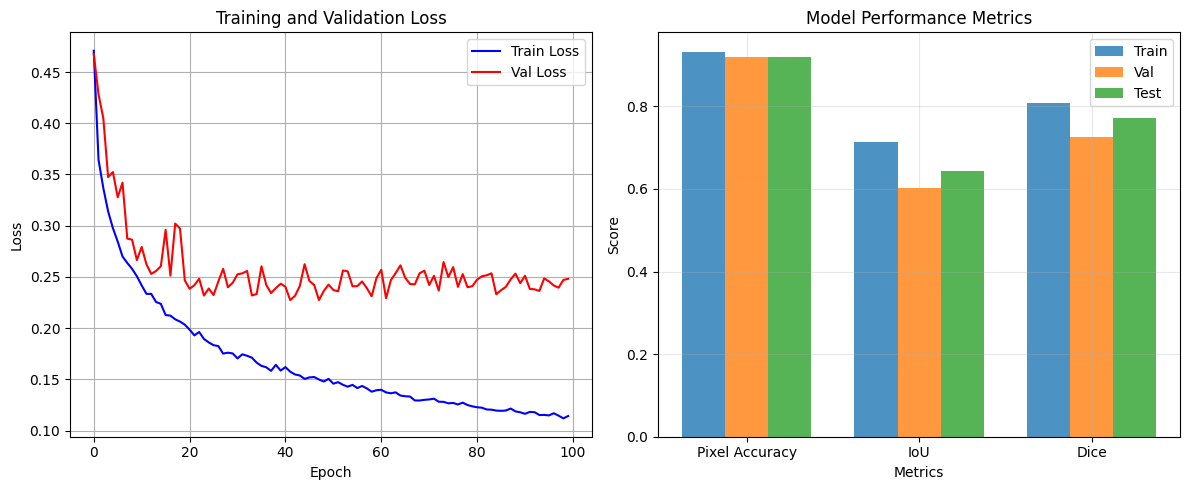

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Calculate and display metrics
print("\nCalculating final metrics...")
train_metrics = calculate_metrics(model, train_loader, device)
val_metrics = calculate_metrics(model, val_loader, device)
test_metrics = calculate_metrics(model, test_loader, device)

print("\nFinal Results:")
print(f"Train - Pixel Acc: {train_metrics['pixel_accuracy']:.4f}, IoU: {train_metrics['iou']:.4f}, Dice: {train_metrics['dice']:.4f}")
print(f"Val   - Pixel Acc: {val_metrics['pixel_accuracy']:.4f}, IoU: {val_metrics['iou']:.4f}, Dice: {val_metrics['dice']:.4f}")
print(f"Test  - Pixel Acc: {test_metrics['pixel_accuracy']:.4f}, IoU: {test_metrics['iou']:.4f}, Dice: {test_metrics['dice']:.4f}")

# Plot metrics
plt.subplot(1, 2, 2)
metrics_names = ['Pixel Accuracy', 'IoU', 'Dice']
train_vals = [train_metrics['pixel_accuracy'], train_metrics['iou'], train_metrics['dice']]
val_vals = [val_metrics['pixel_accuracy'], val_metrics['iou'], val_metrics['dice']]
test_vals = [test_metrics['pixel_accuracy'], test_metrics['iou'], test_metrics['dice']]

x = np.arange(len(metrics_names))
width = 0.25

plt.bar(x - width, train_vals, width, label='Train', alpha=0.8)
plt.bar(x, val_vals, width, label='Val', alpha=0.8)
plt.bar(x + width, test_vals, width, label='Test', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.xticks(x, metrics_names)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:

def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx in indices:
        sample = dataset[idx]
        image = sample["image"].unsqueeze(0).to(device)
        mask = sample["mask"].squeeze().numpy()
        orig_size = sample.get("orig_size", (32, 32))
        
        with torch.no_grad():
            output = model(image)
            output = torch.sigmoid(output)
            pred = output.squeeze().cpu().numpy()
            pred_binary = (pred > 0.5).astype(np.uint8)

        image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)  # CHW → HWC

        # Plotting
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        axes[0].imshow(image_np)
        axes[0].set_title(f"Image\nOrig size: {orig_size[0]}x{orig_size[1]}")
        axes[0].axis("off")

        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        axes[2].imshow(pred, cmap='gray')
        axes[2].set_title(f"Prediction (raw)\nMax: {pred.max():.3f}")
        axes[2].axis("off")
        
        axes[3].imshow(pred_binary, cmap='gray')
        axes[3].set_title("Prediction (binary)")
        axes[3].axis("off")

        plt.tight_layout()
        plt.show()

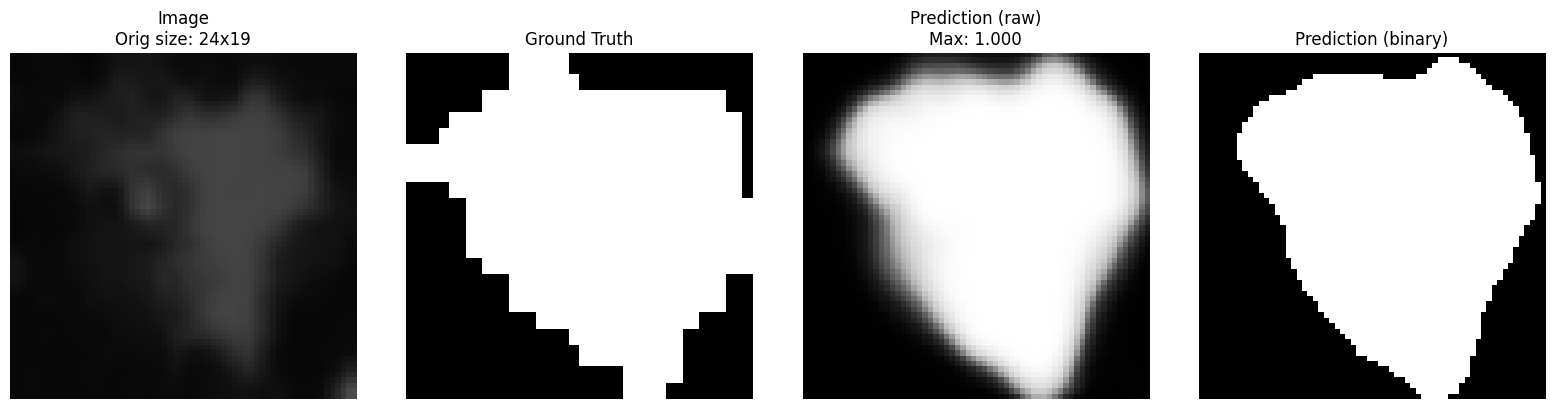

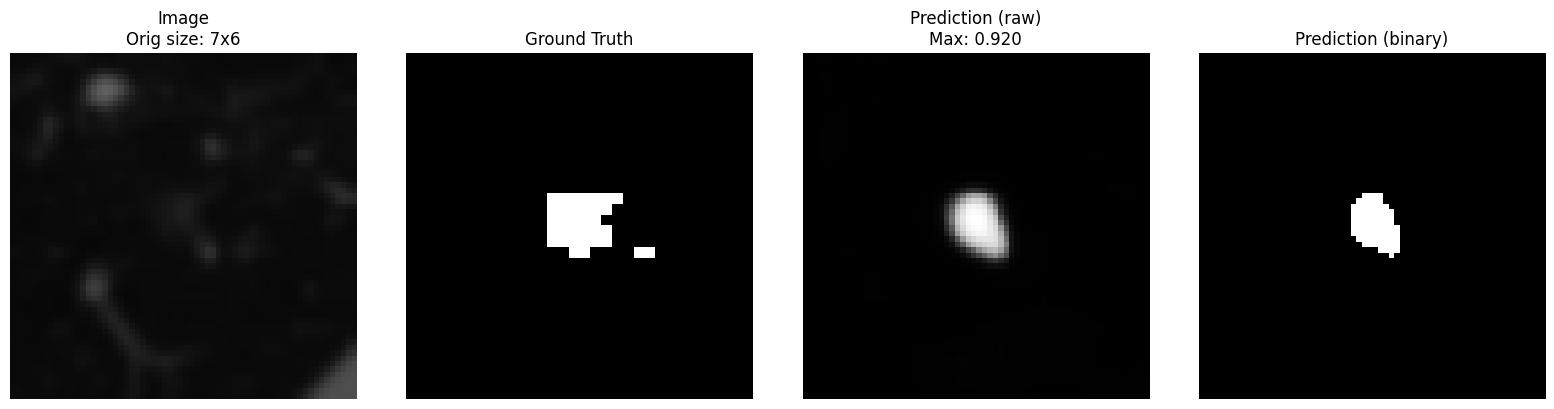

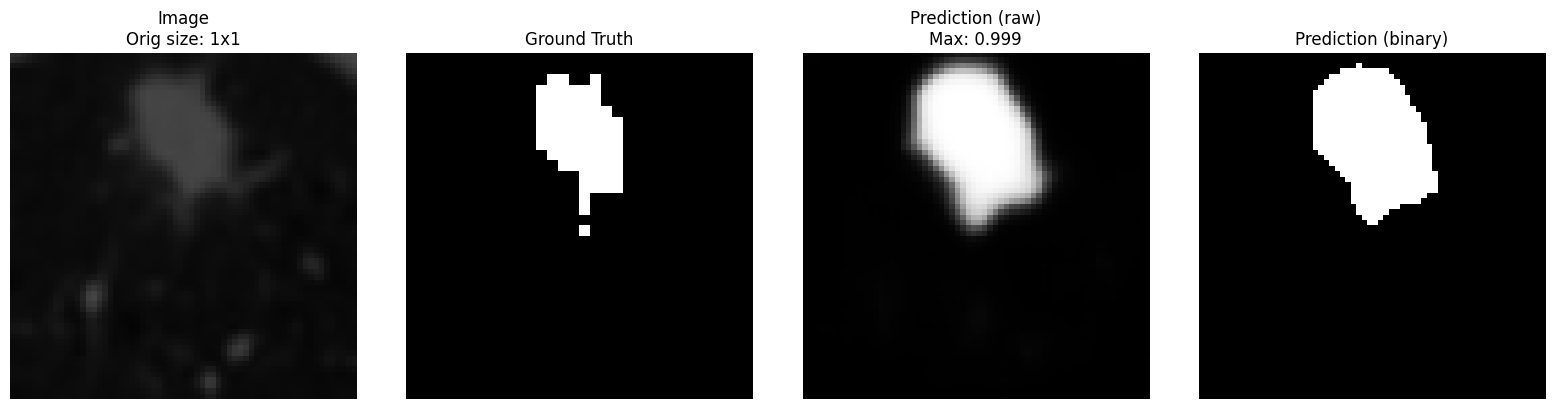

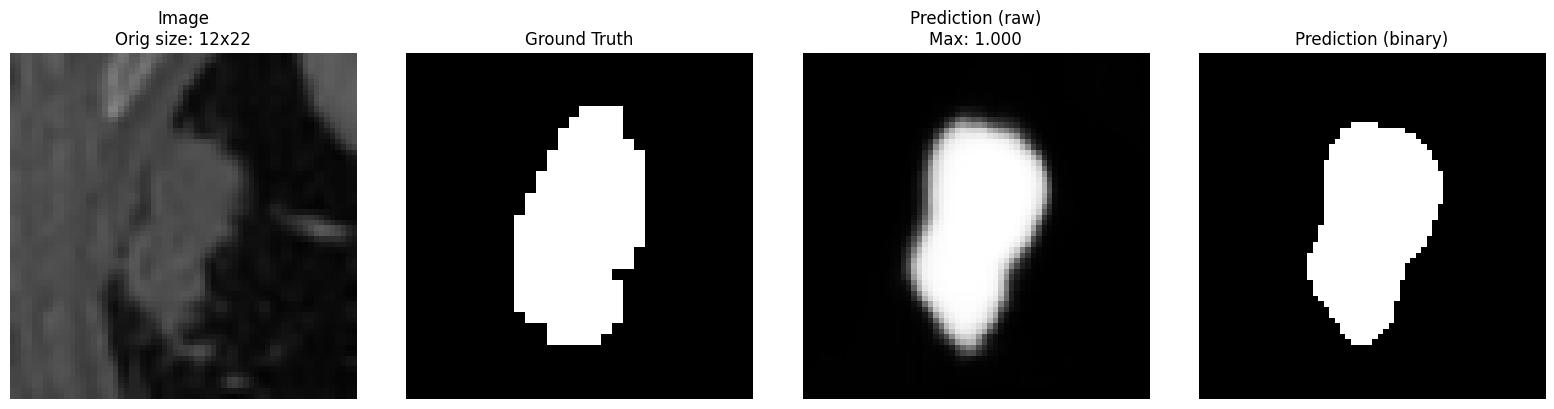

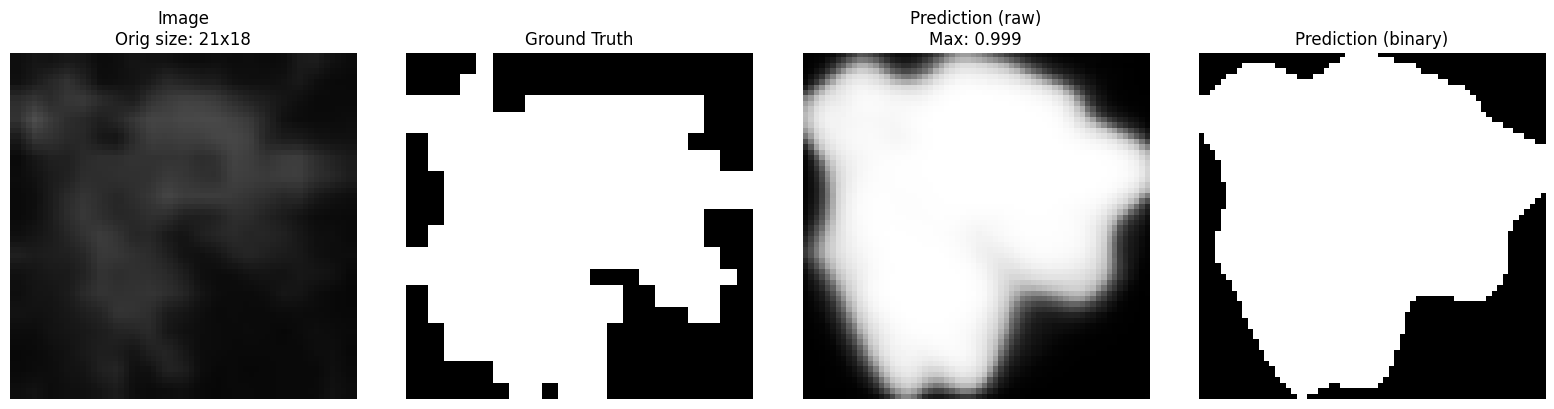

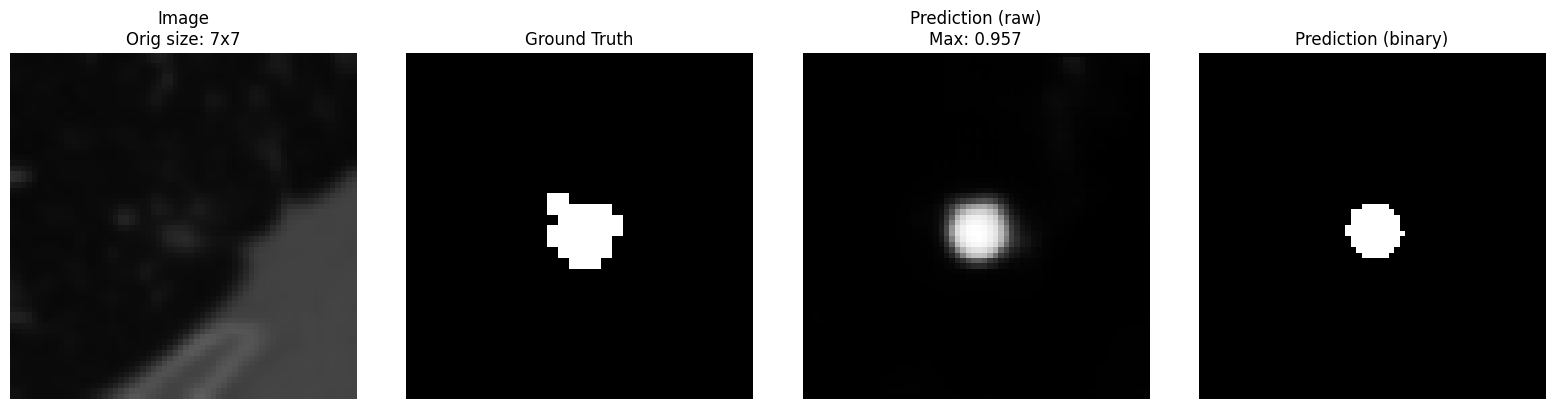

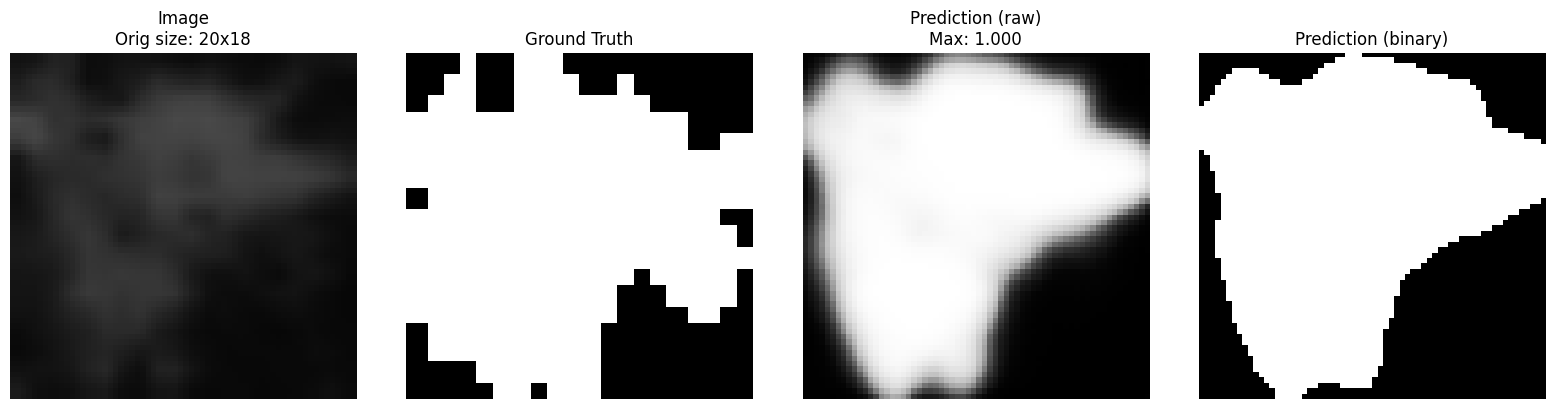

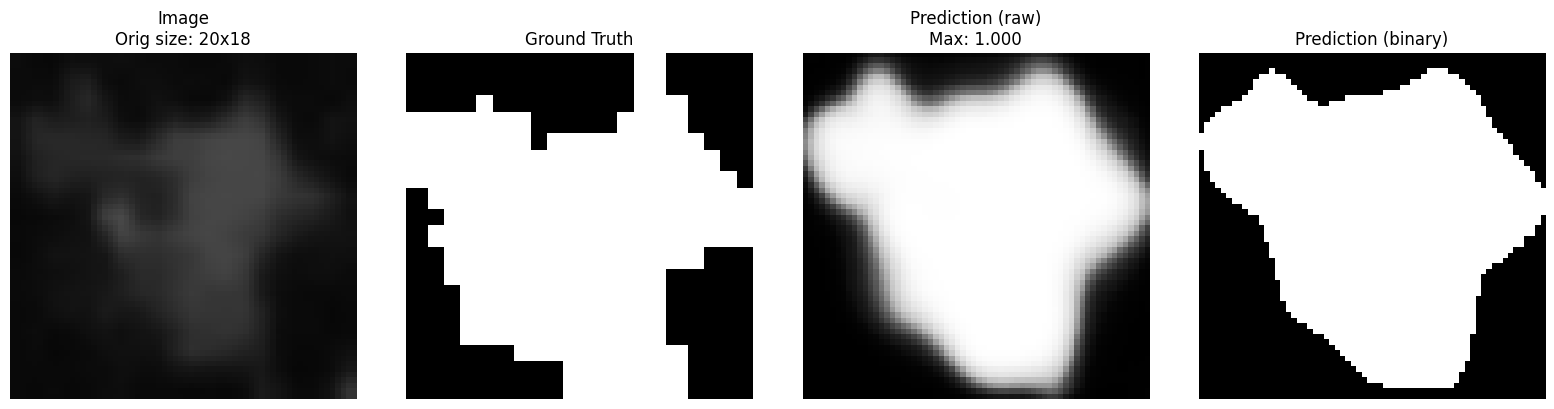

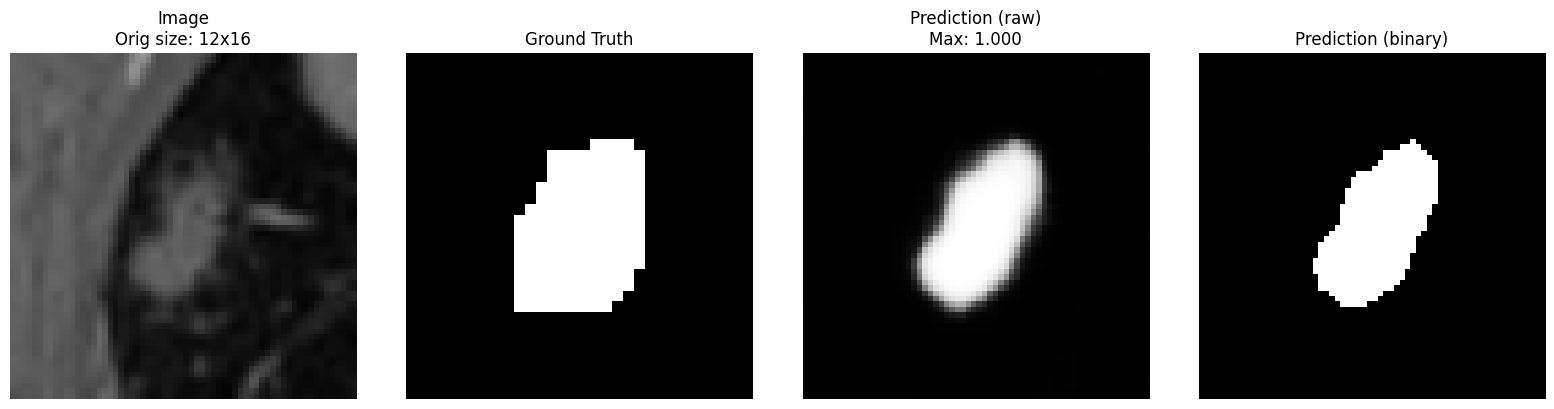

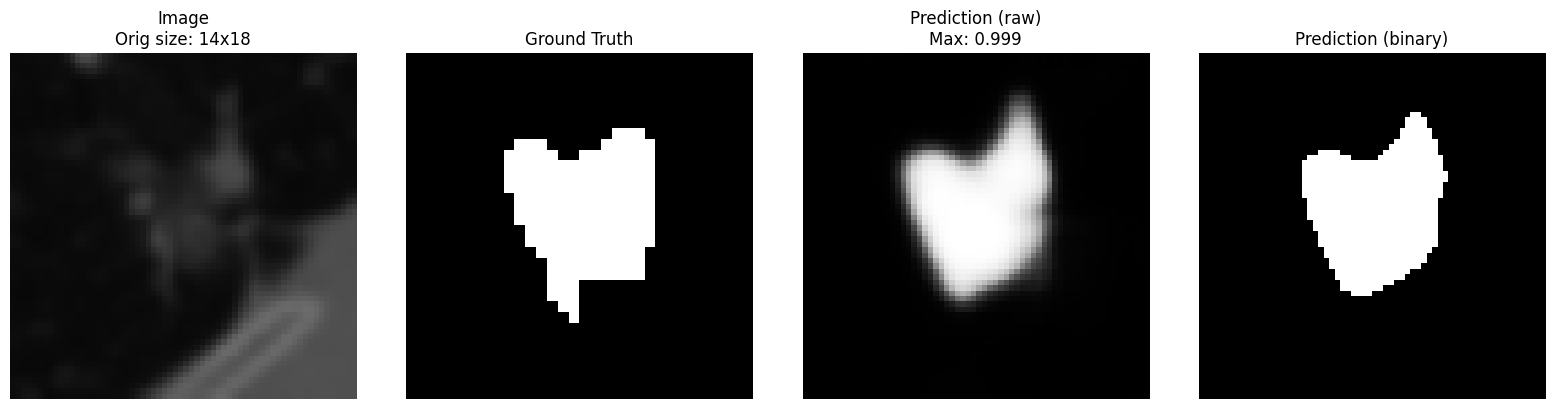

In [23]:
visualize_predictions(model, test_dataset, device, num_samples=10)